# Simulated/"hybrid" Motion

In [1]:
from matplotlib import pyplot as plt
import numpy as np

def plot_auc_CDF(aucs):
    """Plot the cumulative dist function (CDF) of the AUCs."""
    # plt.figure(figsize=(20, 10))
    plt.xlim(0, 1)
    _ = plt.hist(aucs,
                cumulative=True,
                density=True,
                bins=100)


def plot_auc_PDF(aucs):
    """Plot the probability dist function (PDF) of the AUCs."""
    plt.xlim(0, 1)
    plt.hist(aucs, bins=20)

    # plot the mean as a vertical 'tab:orange' line
    plt.axvline(np.mean(aucs), color='tab:orange', linestyle='--', label=f"Mean: {np.mean(aucs):.3f}")
    plt.legend()

In [2]:
#| export

from typing import List

from pisces.utils import avg_steps
from sklearn.metrics import auc as auc_score

def add_rocs(ax, fprs: List[np.ndarray], tprs: List[np.ndarray], x_class: str = "SLEEP", y_class: str = "WAKE", min_auc: float = 0.0):
    
    aucs = np.array([
        auc_score(fpr, tpr)
        for fpr, tpr in zip(fprs, tprs)
    ])

    all_fprs, avg_curve = avg_steps(
            xs=[list(fprs[i]) for i in range(len(aucs)) if aucs[i] > min_auc],
            ys=[list(tprs[i]) for i in range(len(aucs)) if aucs[i] > min_auc],
        )

    avg_auc = np.mean(aucs[aucs > min_auc])

    ax.step(
        all_fprs,
        avg_curve,
        c="tab:blue",
        where="post",
        label=f"All splits avg ROC-AUC: {avg_auc:0.3f}",
    )
    for roc in zip(fprs, tprs):
        ax.step(roc[0], roc[1], "tab:orange", alpha=0.2, where="post")
    ax.plot([0, 1], [0, 1], "-.", c="black")

    ax.set_ylabel(f"Fraction of {y_class} scored as {y_class}")
    ax.set_xlabel(f"Fraction of {x_class} scored as {y_class}")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

In [3]:
import matplotlib.pyplot as plt
from pisces.experiments import DataSetObject


sets = DataSetObject.find_data_sets("../data_sets")
w = sets['walch_et_al']
hybrid = sets['hybrid_motion']

# (MO) Pretrained UNet evaluation
We have the trained weights from Mads Olsen et al.'s _ResUNet_ model, saved as a tensorflow lite model with a wrapper for our system. This section calls that on accelerometer recordings in the `'walch_et_al'` data set.

In [4]:
from pisces.experiments import MOResUNetPretrained


mo = MOResUNetPretrained()


### Walch et al. data set

In [5]:
# uses all processors on your CPU to preprocess the accelerometer into spectrograms
# takes ~ 50 sec on M1 Pro (10core)
mo_preprocessed_data = mo.prepare_set_for_training(w, w.ids)

resampling to 0.031s from 0.015s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.015s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.015s
resampling to 0.031s from 0.100s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.015s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.100s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.020s
resampling to 0.031s from 0.030s
resampling

In [6]:
from dataclasses import dataclass
from typing import List

import numpy as np

from sklearn.metrics import roc_auc_score, roc_curve

from pisces.utils import pad_to_hat

evaluations: List[dict] = []
for i, (X, y) in enumerate(mo_preprocessed_data):
    y_hat_proba = mo.predict_probabilities(X)
    y_hat_sleep_proba = (1 - y_hat_proba[:, :, 0]).reshape(-1,)
    y_flat = y.reshape(-1,)
    n_sleep = np.sum(y_flat > 0)
    n_wake = np.sum(y_flat == 0)
    N = n_sleep + n_wake

    balancing_weights_ignore_mask = np.where(y_flat > 0, N / n_sleep, N / n_wake)


    # adjust y to match the lenght of y_hat, which was padded to fit model constraints
    y_padded = pad_to_hat(y, y_hat_sleep_proba)
    # make a mask to ignore the padded values, so they aren't counted against us
    mask = pad_to_hat(balancing_weights_ignore_mask, y_hat_sleep_proba)
    # mask = pad_to_hat(y_flat, y_hat_sleep_proba)

    # also ignore any unscored or missing values.
    mask *= y_padded >= 0
    # roc_auc will complain if -1 is in y_padded
    y_padded *= y_padded >= 0

    this_auc = roc_auc_score(y_padded, y_hat_sleep_proba, sample_weight=mask)
    fprs, tprs, _ = roc_curve(y_padded, y_hat_sleep_proba, sample_weight=mask)
    print(f"Processing {i+1} of {len(mo_preprocessed_data)} ({w.ids[i]})... AUROC: {this_auc}")

    evaluations.append({"y_padded": y_padded, "y_hat": y_hat_sleep_proba, "mask": mask, "auc": this_auc, "roc_curve": {"tprs": tprs, "fprs": fprs}})

1/1 [==============================] - 1s 732ms/step
Processing 1 of 31 (1066528)... AUROC: 0.6472765464290914
1/1 [==============================] - 0s 289ms/step
Processing 2 of 31 (1360686)... AUROC: 0.7263517335719533
1/1 [==============================] - 0s 280ms/step
Processing 3 of 31 (1449548)... AUROC: 0.7331730769230784
1/1 [==============================] - 0s 312ms/step
Processing 4 of 31 (1455390)... AUROC: 0.3950850144879998
1/1 [==============================] - 0s 279ms/step
Processing 5 of 31 (1818471)... AUROC: 0.6492616033755216
1/1 [==============================] - 0s 280ms/step
Processing 6 of 31 (2598705)... AUROC: 0.6579764453961519
1/1 [==============================] - 0s 278ms/step
Processing 7 of 31 (2638030)... AUROC: 0.6225375708302563
1/1 [==============================] - 0s 283ms/step
Processing 8 of 31 (3509524)... AUROC: 0.732886324653047
1/1 [==============================] - 0s 296ms/step
Processing 9 of 31 (3997827)... AUROC: 0.6636655948553136
1/

In [7]:
mo_aucs = [e["auc"] for e in evaluations]

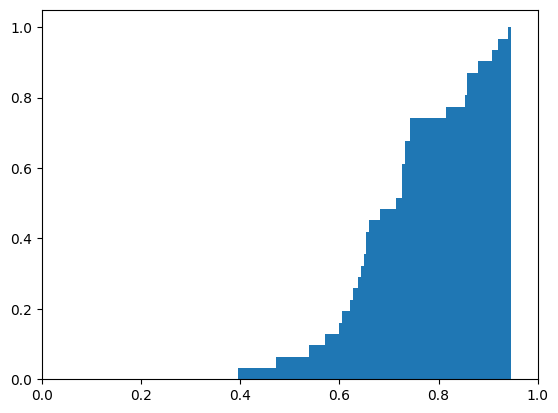

In [8]:
plot_auc_CDF(mo_aucs)

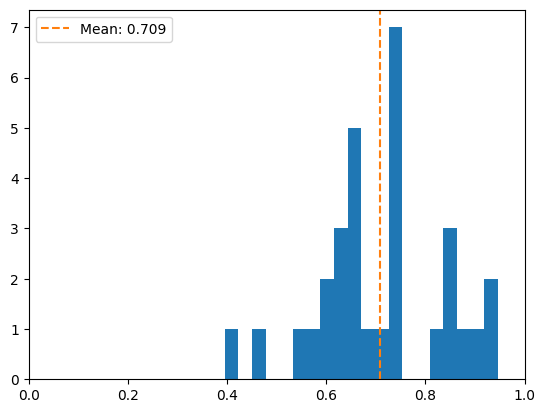

In [9]:
# y so terrible??
# probably timestamp/gap issues
# look at worst ones
plot_auc_PDF(mo_aucs)

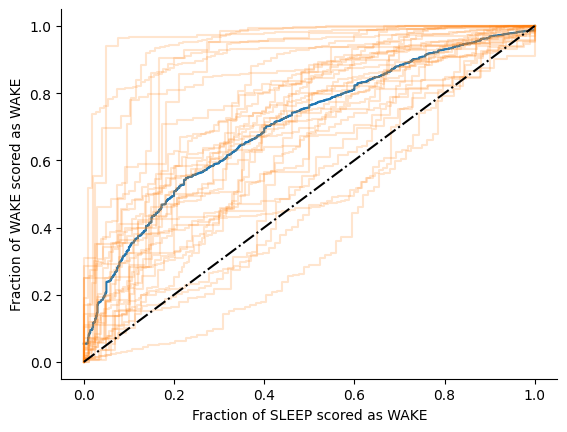

In [10]:
fprs = [e["roc_curve"]["fprs"] for e in evaluations]
tprs = [e["roc_curve"]["tprs"] for e in evaluations]

fig, ax = plt.subplots()
add_rocs(ax, fprs, tprs)

### debugging

In [11]:
import random

from pisces.experiments import MOResUNetPretrained


w = sets['walch_et_al']
subj = w.ids[1]
X, y = mo_preprocessed_data[1]
print("X.shape =", X.shape)
spec = X[0, 1:, :, 0].T

print("spec.shape =", spec.shape)


X.shape = (1, 15360, 32, 2)
spec.shape = (32, 15359)


In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def plot_spectrogram(preprocessed_data, idx):
    X, y = preprocessed_data[idx]
    spec = X[0, 1:, :, 0].T

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

    # ax1.imshow(.T)

    img = ax1.imshow(spec, origin="lower", aspect="auto")#, vmin=vmin, vmax=vmax)
    ax1.set_title('Spectrogram, Time : Freq')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Freq')

    axins = inset_axes(ax1,
                    width="5%",  # width = 5% of parent_bbox width
                    height="75%",  # height : 50%
                    loc='center right')

    plt.colorbar(img, cax=axins, orientation="vertical")

    ax3.plot(spec)
    ax3.set_title('Spectrogram, Frequency : Power ')
    ax3.set_xlabel('Freq')
    ax3.set_ylabel('Power')
    ax3.set_xlim(0, 31)#spec.shape[0])


    ax2.plot(spec.T)
    ax2.set_title('Spectrogram, Time : Power')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Power')
    ax2.set_xlim(0, spec.shape[1])


    plt.tight_layout(pad=0.3)
    plt.show()


In [24]:

def plot_predictions(evaluations, y_time, idx):
    y_pad = evaluations[idx]["y_padded"][:len(y_time)]
    y_pred = evaluations[idx]["y_hat"][:len(y_time)]
    y_mask = evaluations[idx]["mask"][:len(y_time)]

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(y_time, y_pad, label="True")
    ax.plot(y_time, y_pred, label="Predicted")
    ax.plot(y_time, y_mask, label="Mask")
    ax.legend(loc='upper right')

/var/folders/vg/z_53ht1x3g74yklxt7y2bc540000gn/T/ipykernel_17703/3861356183.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.3)


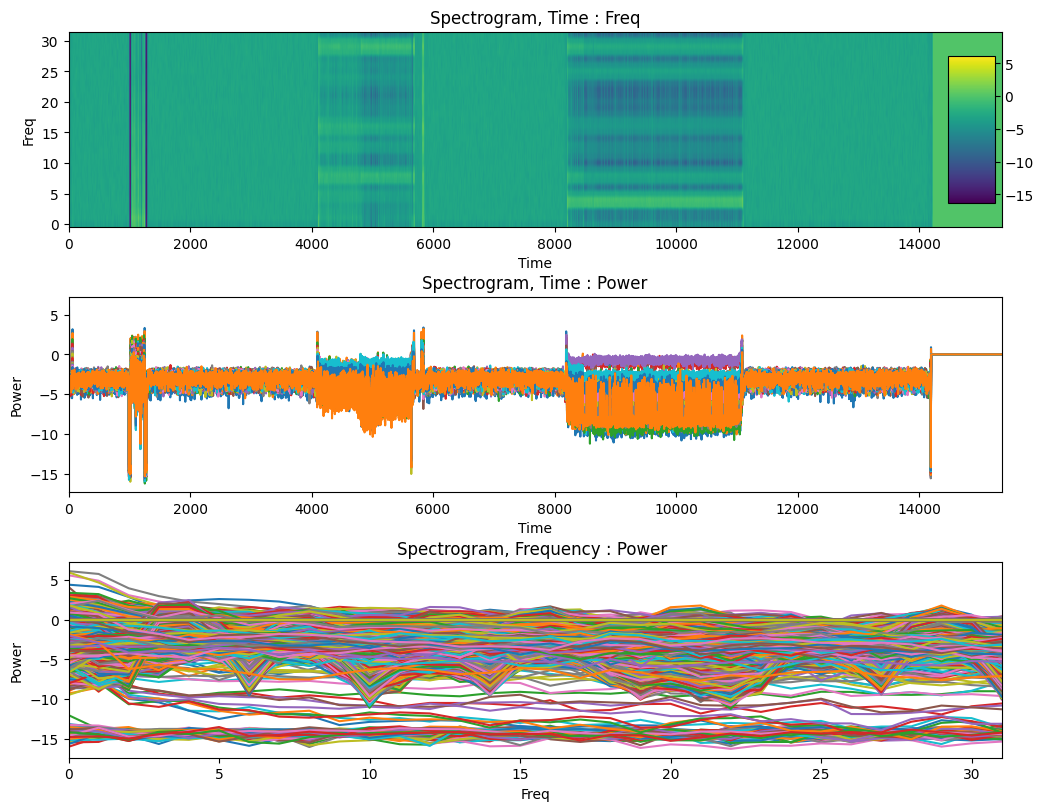

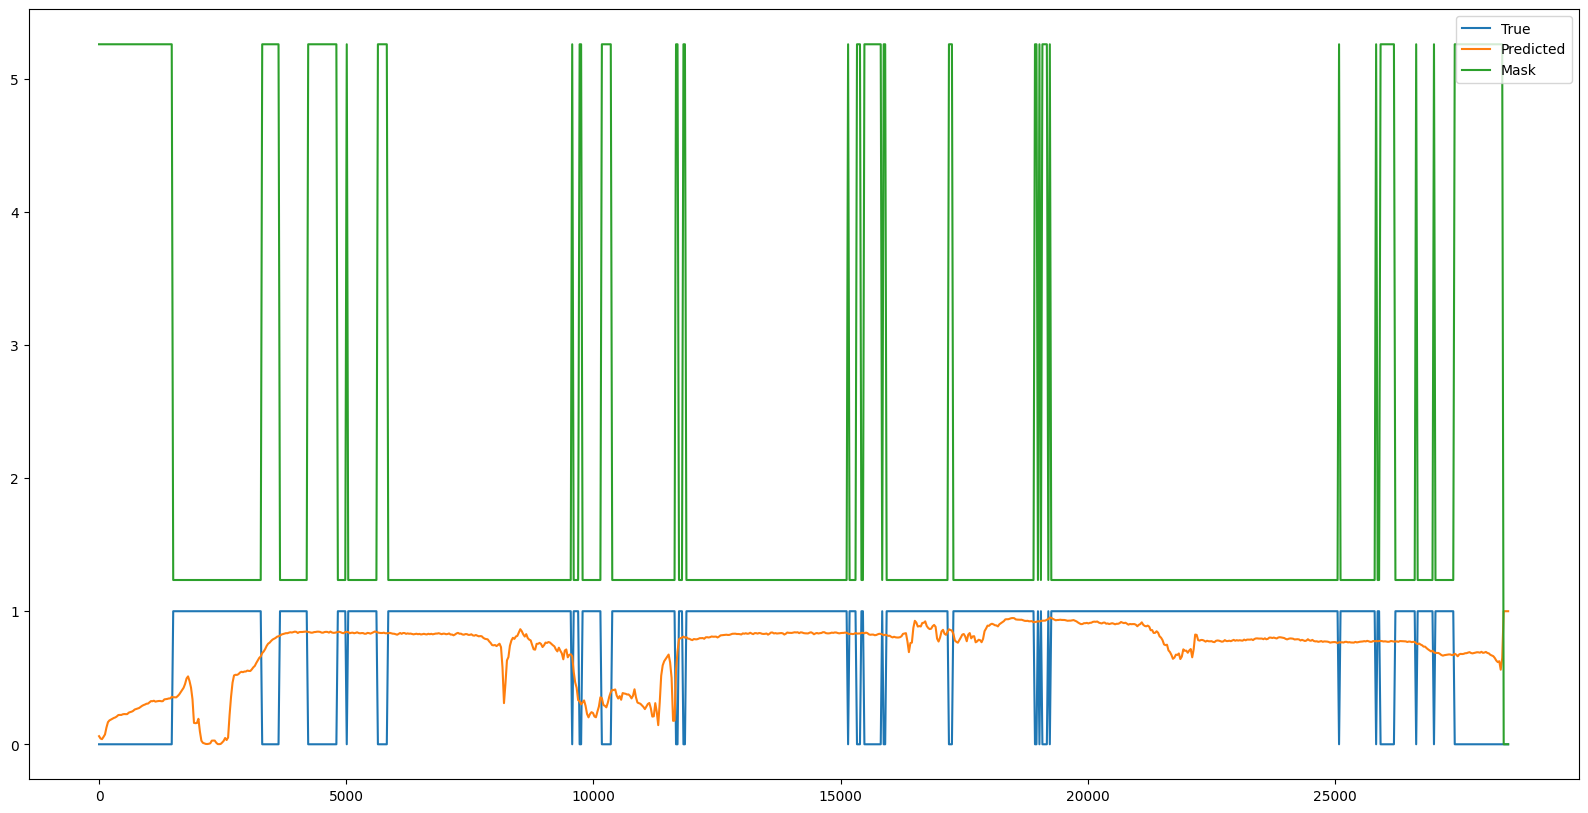

In [26]:
index = 0
psg = w.get_feature_data("psg", w.ids[index])
psg_time = psg[:, 0].to_numpy()

plot_spectrogram(mo_preprocessed_data, index)
plot_predictions(evaluations=evaluations, y_time=psg_time, idx=index)

/var/folders/vg/z_53ht1x3g74yklxt7y2bc540000gn/T/ipykernel_17703/3861356183.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.3)


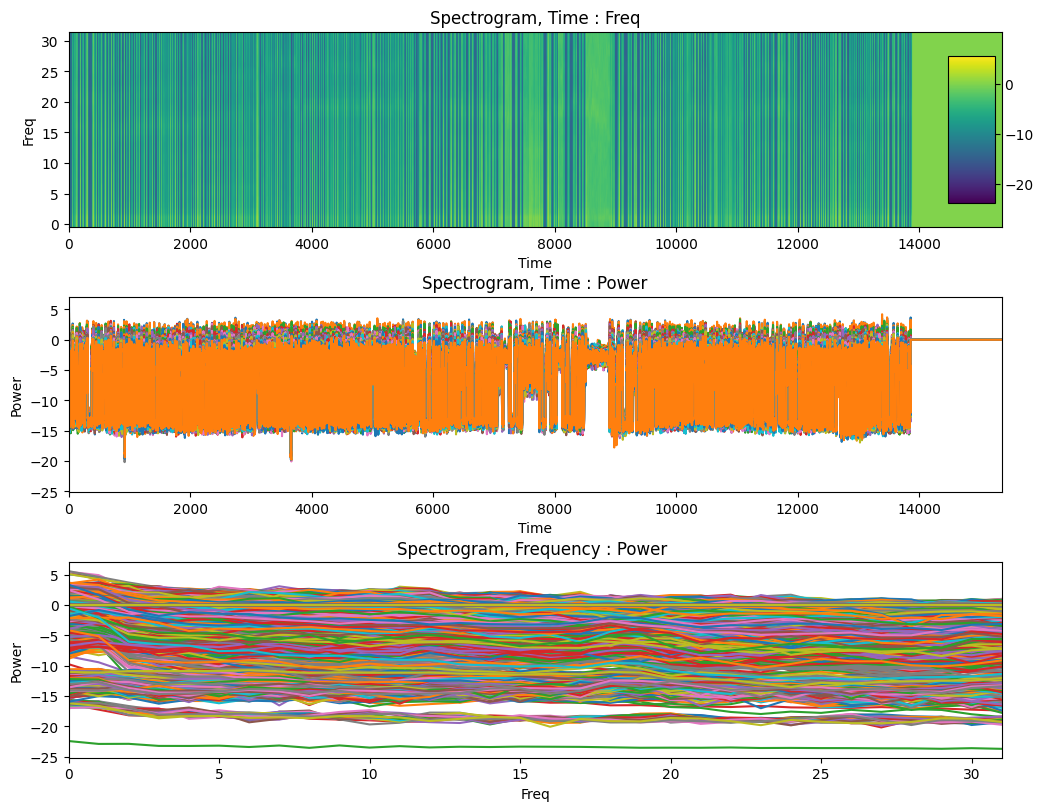

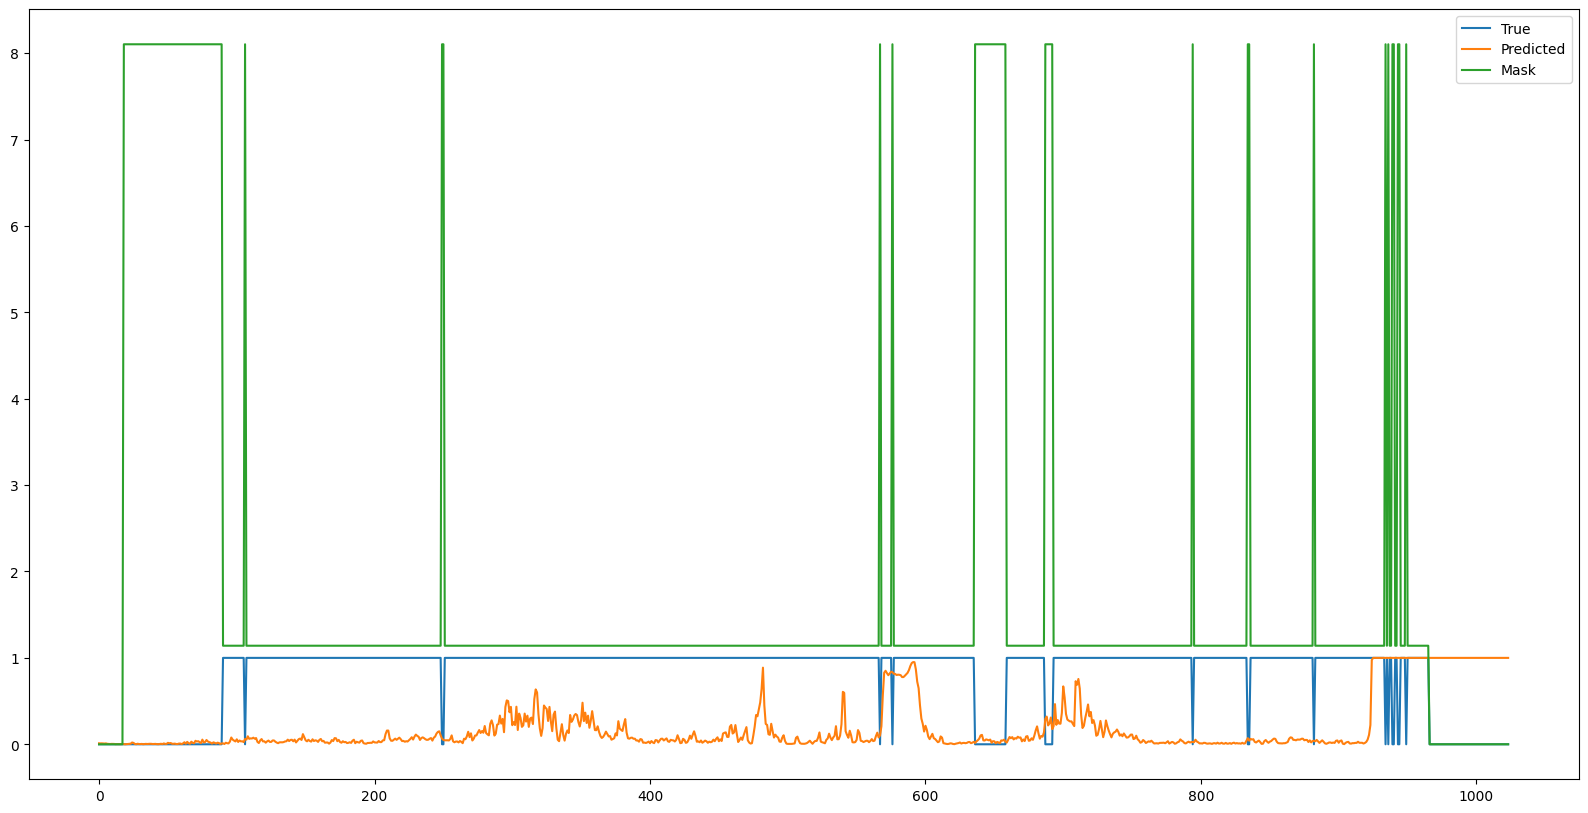

In [15]:
index = 1
plot_spectrogram(mo_preprocessed_data, index)
plot_predictions(evaluations, index)

/var/folders/vg/z_53ht1x3g74yklxt7y2bc540000gn/T/ipykernel_17703/3861356183.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.3)


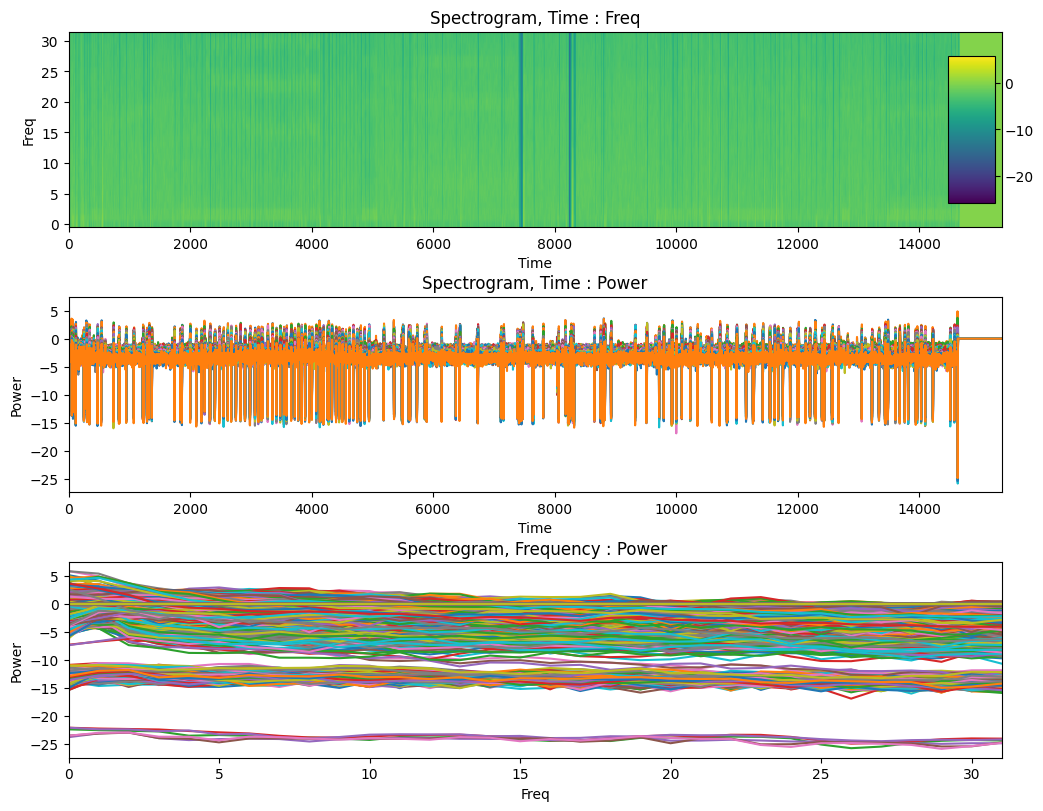

In [16]:
plot_spectrogram(mo_preprocessed_data, 14)

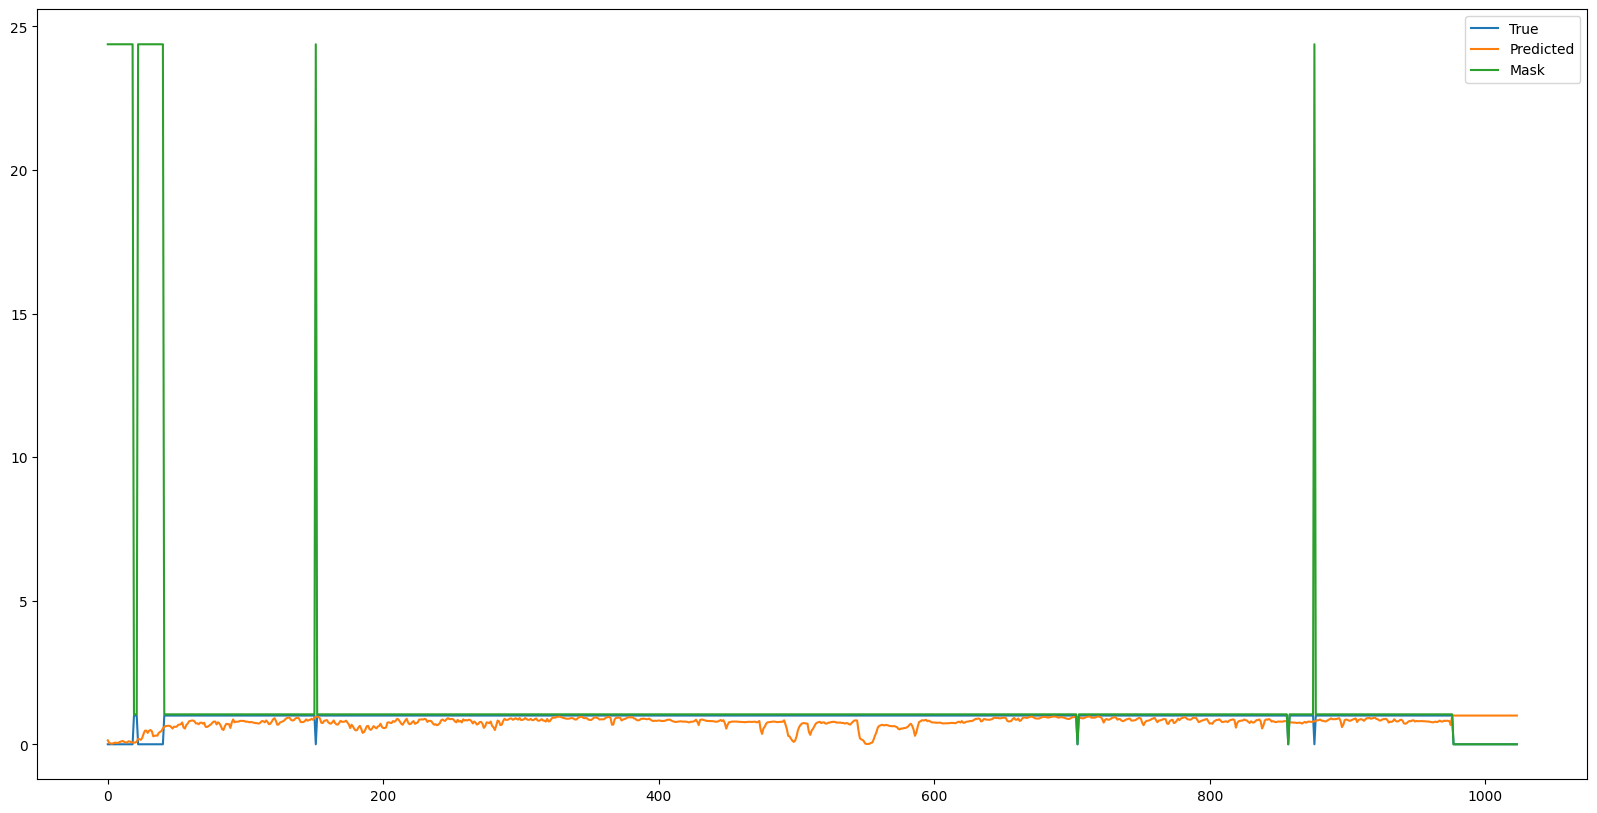

In [17]:
plot_predictions(evaluations, 14)

/var/folders/vg/z_53ht1x3g74yklxt7y2bc540000gn/T/ipykernel_17703/3861356183.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.3)


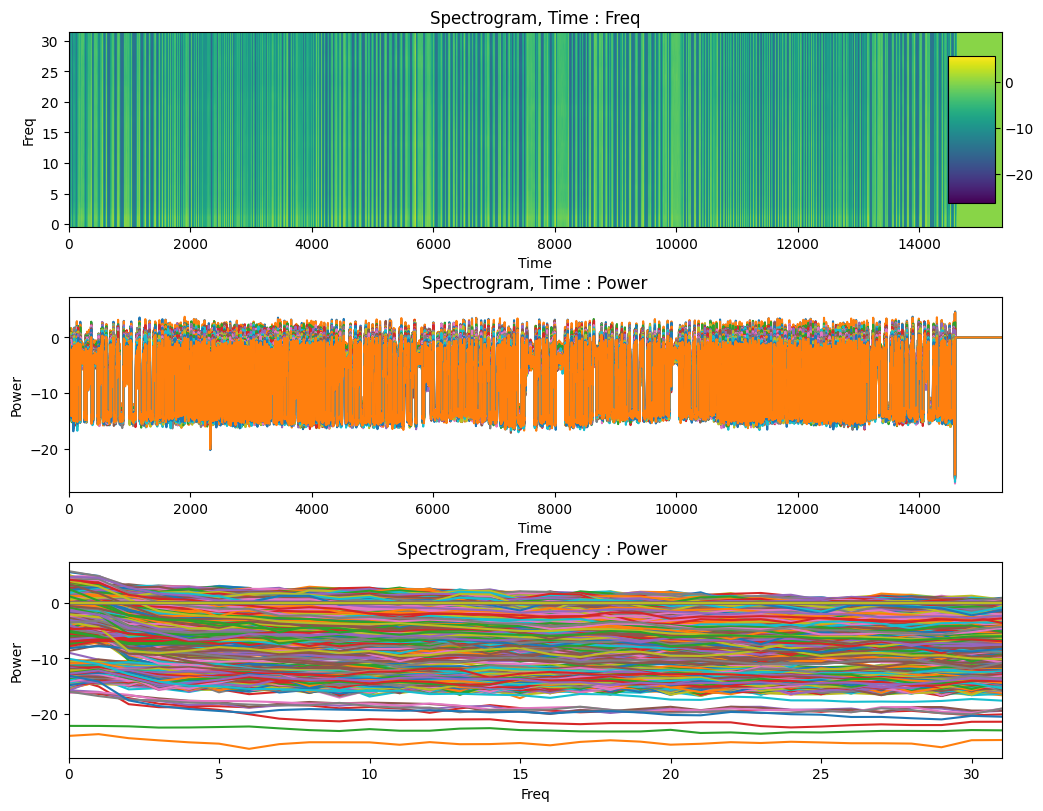

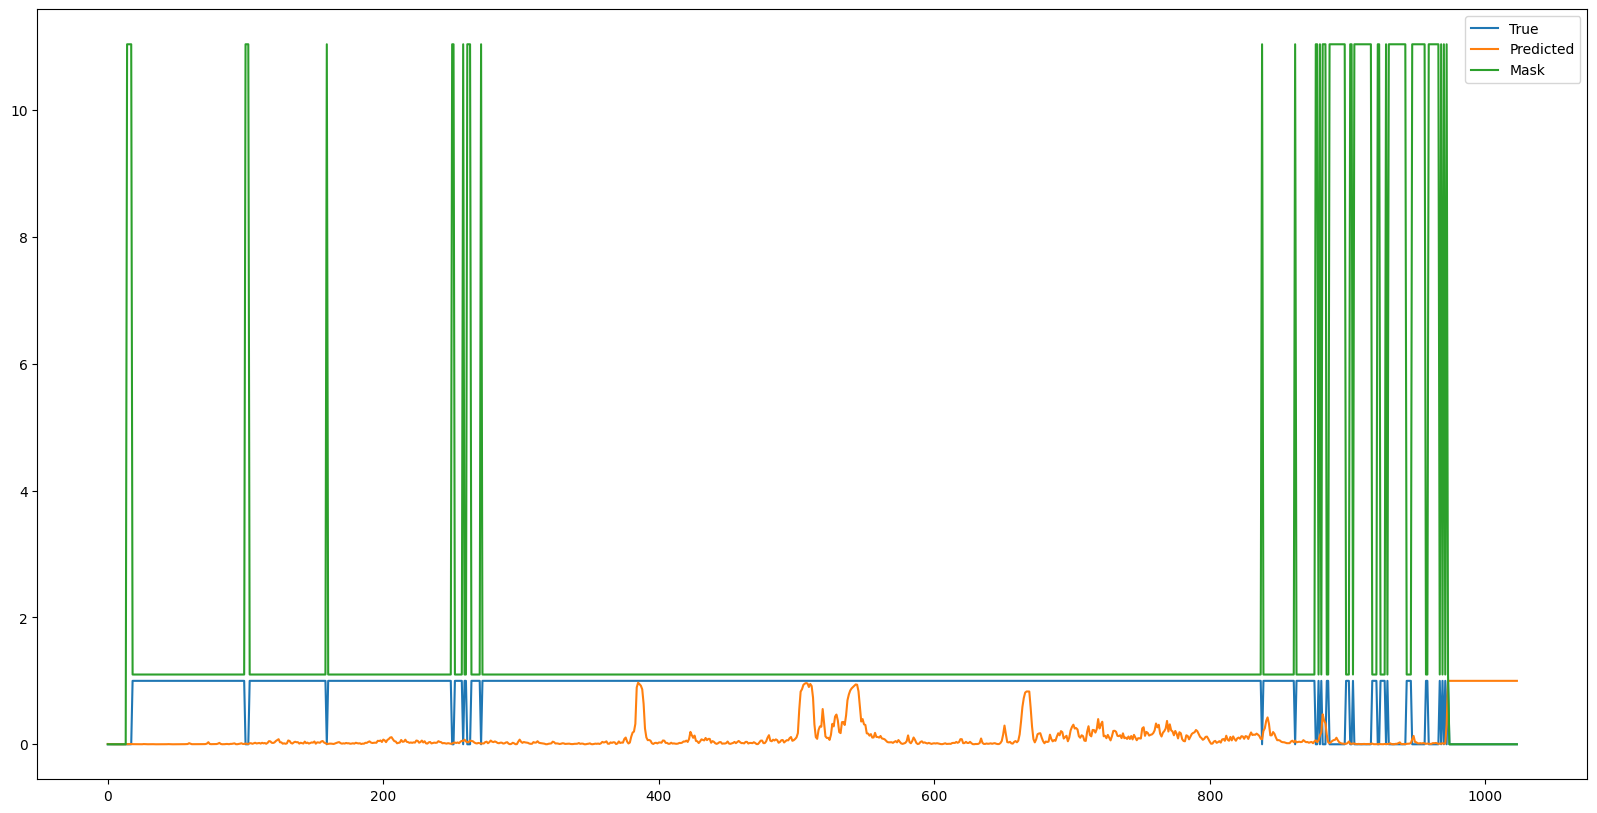

In [18]:
index = 28
plot_spectrogram(mo_preprocessed_data, index)
plot_predictions(evaluations, index)

# LOO + SGD Log Reg classifier
Adding LOOX can be achieved by training on 'walch_et_al' and testing on 'hybrid_data'.

In [19]:

from pisces.experiments import LeaveOneOutSplitter, SGDLogisticRegression, run_splits


loo = LeaveOneOutSplitter()

split_models, log_reg_preprocessed_data, splits = run_splits(loo, sets['walch_et_al'], 500, SGDLogisticRegression)

31it [00:03,  8.07it/s]


prediction: (914,), labels: (956,)


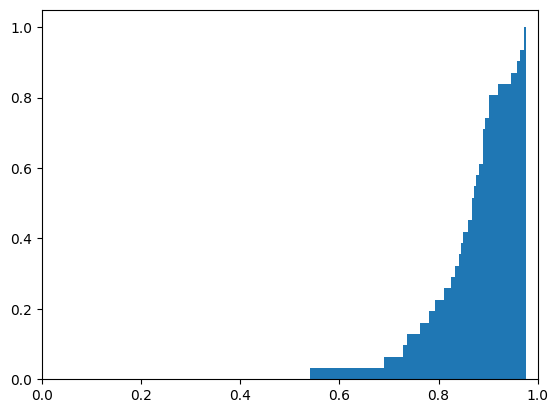

In [20]:

import matplotlib.pyplot as plt

SPLIT_NUMBER = 0

log_reg_aucs = [
    split_models[i].roc_auc(
        log_reg_preprocessed_data[
            splits[i][1][0]])
    for i in range(len(split_models))
]

plot_auc_CDF(log_reg_aucs)

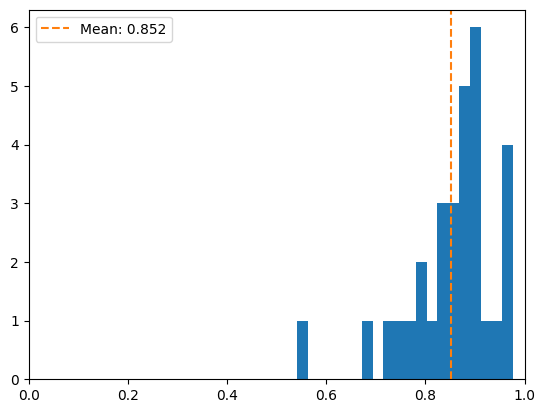

In [21]:
plot_auc_PDF(log_reg_aucs)

prediction: (914,), labels: (956,)


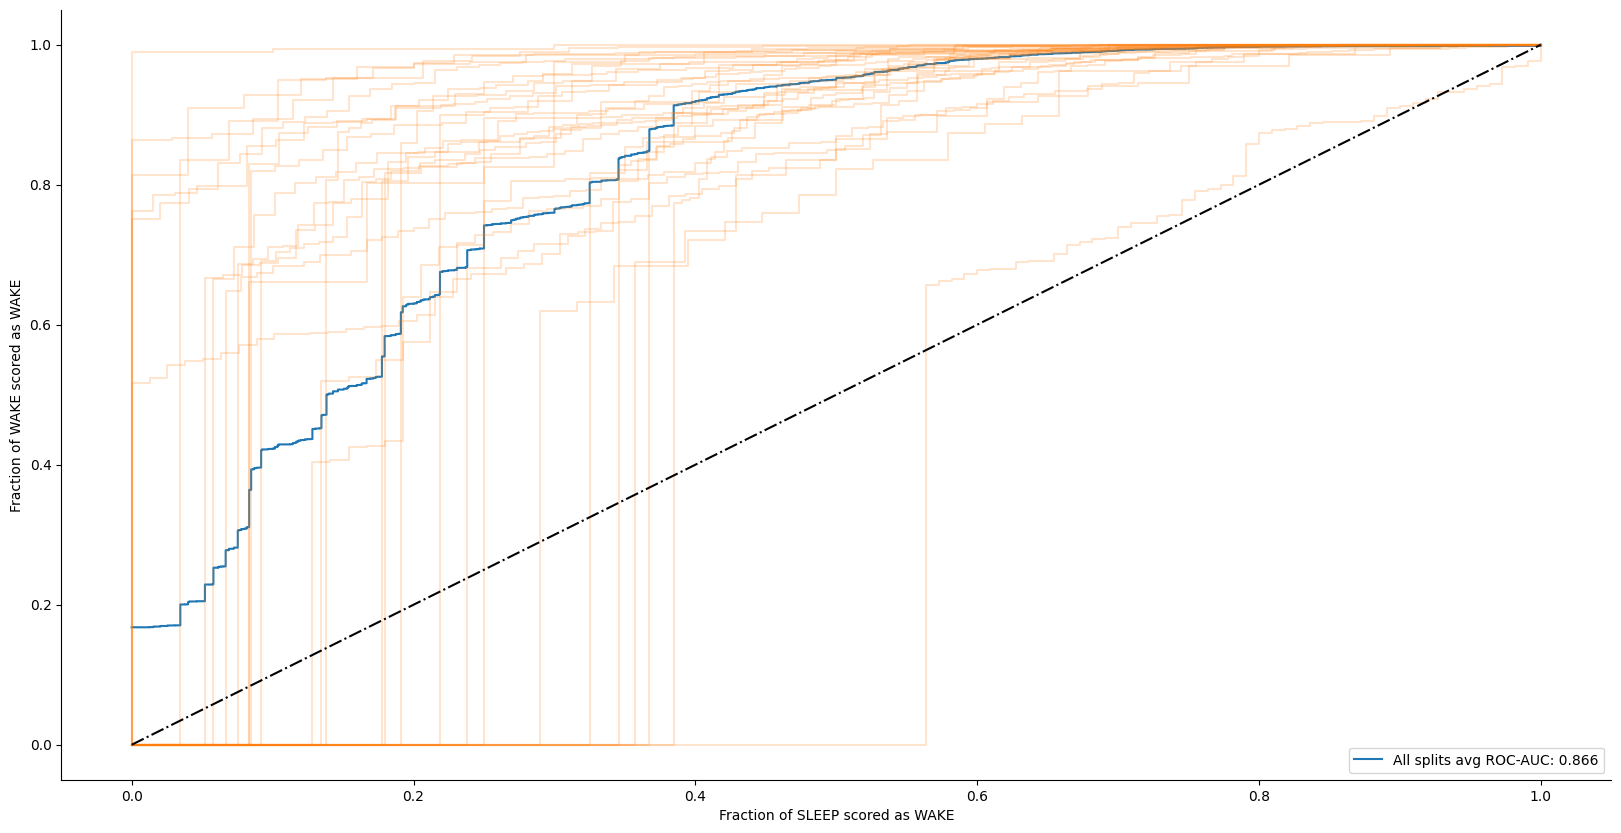

In [22]:


roc_curves = [
    split_models[i].roc_curve(
        log_reg_preprocessed_data[
            splits[i][1][0]])
    for i in range(len(split_models))
]
fig, ax = plt.subplots(figsize=(20, 10))
add_rocs(
    ax, 
    [fpr for fpr, _ in roc_curves], 
    [tpr for _, tpr in roc_curves],
    min_auc=0.7)
ax.legend(loc='lower right')